# Decision trees

Noter til diskussion
- skal vi lave en train split, så vi i bunden også kan vise hvor god træet er til at forudsige?
- slå koderne sammen - lav en True/False efter hvilken type vi kører, BDT eller NN
- lav function til at plotte så den kun kører en gang

In [50]:
# Importer pakker der skal bruges

# Pakker til at behandle data
import pandas as pd
import numpy as np

# Pakker til at plotte
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping



## Inspicer dataen

Først vil vi gerne undersøge hvilken data vi har med at gøre. 

In [51]:
# importer data fra csv-fil (excel)
data = pd.read_csv('HousingPrices_selected.csv', sep=',')
data.head(5) # vis de første 5 rækker data

,Postnummer,Husnummer,Kvadratmeter,Grundareal,Byggeår,Afstand_skole,Afstand_supermarked,Salgspris,Type
0,4953.0,9.0,97,949.0,1942.0,5425.42,5551.78,1050000,2
1,2300.0,12.0,86,0.0,2006.0,1045.23,132.97,1352500,1
2,2300.0,12.0,86,0.0,2006.0,1045.23,132.97,3500000,1
3,2300.0,16.0,95,0.0,2007.0,1017.53,153.93,3463432,1
4,2300.0,18.0,73,0.0,2007.0,1004.49,166.23,2700000,1


## Parameter

In [52]:
classification = False
regression = True
DT_N_lag = 2                # Hvor mange lag der er i træet


Max dybde af træet: 2


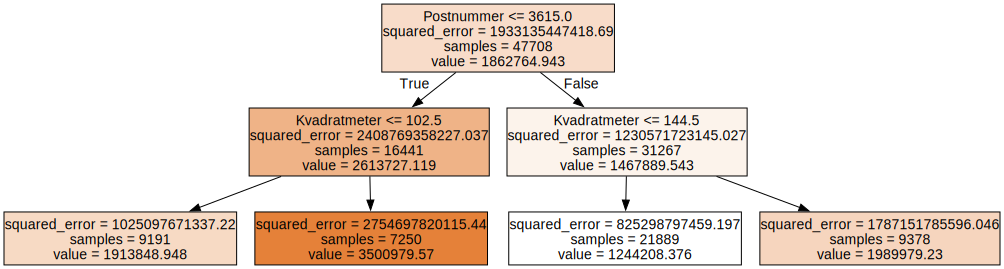

In [53]:
if classification == True:
    forudsig = 'Type'      # Hvilken parameter vi gerne vil forudsige i vores data

if regression == True:
    forudsig = 'Salgspris'


# Deler dataen op i det vi gerne vil lære at forudsige (truth_data) og resten (input_data)
variabler       = data.columns
input_variabler = variabler[(variabler != forudsig)]
input_data      = data[input_variabler]
truth_data      = data[forudsig]


# Her bliver modellen trænet på data
if classification == True:
   estimator = DecisionTreeClassifier(max_depth=DT_N_lag, min_samples_leaf = 20,random_state=42)

if regression == True:
   estimator = DecisionTreeRegressor(max_depth=DT_N_lag, min_samples_leaf = 20,random_state=42)

estimator.fit(input_data, truth_data)   # Dette er den "magiske" linje - her optimerer Machine Learning algoritmen sine interne vægte til at give bedste svar

# laver visuel graf af træet
graph = Source(tree.export_graphviz(estimator, out_file=None, feature_names=input_data.columns, filled=True, max_depth=50))                     
print("Max dybde af træet:", estimator.get_depth()) 
display(SVG(graph.pipe(format='svg')))

### Ideer til at lege rundt med koden

- Inspicer træet. Forstår du/I, hvad de forskellige tal betyder?
  Hvilken type bolig passer flest eksempler ned i, i lag 2? Hvad er algoritmens bud på deres pris (dvs. gennemsnitsprisen)?
- Prøv at ændre på hvor mange lag der er i træet fra 2 til 3.
  Hvilken parameter bliver brugt oftest til at opdele data? Tror du/I at den så er den vigtigste parameter?
  Kan du/I ud fra træet sige mere generelt hvilke parametre der betyder mest for prisen? Hvilke betyder mindst?

# Boosted Decision Tree

Nu hvor vi har set hvordan træet virker, vil vi gerne prøve at forudsige værdien på huse som vi ikke kender salgsprisen på.
Som vi har set, kan det være svært at minimere vores 'loss function'. En måde at forbedre på er ved at køre boosted decision trees, hvilket vil sige at vi kører flere træer, hvor den hver gang lærer af fejlene fra det forrige træ, og på den måde bliver "boostet" for hvert træ den laver.

In [54]:
# vi bruger train_test_split til at splitte data i et træningssæt og et testsæt.
# træningssættet bruges til at træne modellen, hvor modellen får salgspriserne at vide.
# testsættet bruges til at give den trænede model data uden salgspriser, som den så skal forudsige.

data_træning, data_test, sande_pris_træning, sande_pris_test = \
    train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

In [55]:
# Vi giver træningsdata og testsdata til LightGBM:
lgb_train = lgb.Dataset(data_træning, sande_pris_træning)
lgb_test  = lgb.Dataset(data_test,  sande_pris_test, reference=lgb_train)
    
# Her sætter vi "Hyper parametre" for modellen.
hyper_parameters = {
    'objective': 'regression', # regression bruges når vi gerne vil forudsige en kontinuert værdi
    'metric': 'mae',           # hvilken 'fejl' den skal bruge til at optimere efter. 
    'num_leaves': 10,          # antal blade pr. træ
    'num_boost_round': 10      # Hvor mange "runder" den må køre for at optimere
}

# Træn modellen:
gbm_test = lgb.train(
        hyper_parameters,                   # Hyper parametre som vi definerede ovenfor
        lgb_train,                          # Data til at træne modellen
        valid_sets=lgb_test,                # Data til at teste modellen
        callbacks=[early_stopping(15)]      # Stop med at optimere hvis der ikke ses forbedringer efter N antal runder.
)     
                                                    

# Lav forudsigelser med den trænede model
forudsagte_pris = gbm_test.predict(data_test, num_iteration=gbm_test.best_iteration)  

# vi bruger r^2 til at vurdere resultatet. Jo tættere på 1, jo bedre er den til at forudsige.
r2 = r2_score(sande_pris_test, forudsagte_pris)
print(f"R²: {r2:.3f}")
print(f"MAE: {mean_absolute_error(sande_pris_test, forudsagte_pris):,.0f}")
    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 35781, number of used features: 8
[LightGBM] [Info] Start training from score 1867082.744613
Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 744341
R²: 0.410
MAE: 744,341


/var/folders/cv/4hkgm9gn1dv2hp0k2jlt7qrm0000gn/T/ipykernel_42664/1961450947.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/cv/4hkgm9gn1dv2hp0k2jlt7qrm0000gn/T/ipykernel_42664/1961450947.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


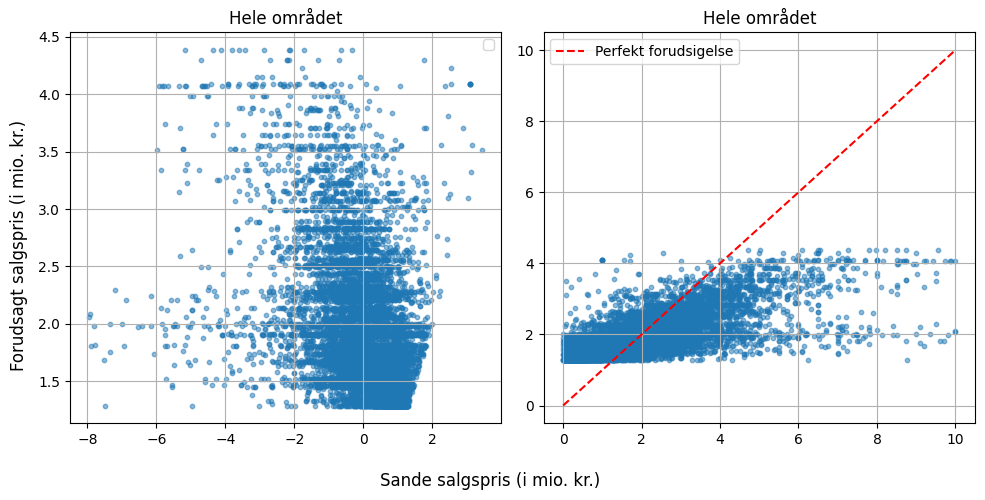

In [56]:
# Vi plotter de forudsagte værdier mod de sande værdier. 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mio = 1e6 # vi dividerer med 10^6 for at få tallene i hele milioner.

###---- VENSTRE PLOT -----###
ax = axes[0]
ax.scatter((forudsagte_pris - sande_pris_test)/mio, forudsagte_pris/mio, alpha=0.5, s=10)
ax.grid(True)
ax.legend()
ax.set_title('Hele området')

###---- HØJRE PLOT -----###
ax = axes[1]
ax.scatter(sande_pris_test/mio, forudsagte_pris/mio, alpha=0.5, s=10)
ax.plot([np.min(sande_pris_test/mio), np.max(sande_pris_test/mio)], [np.min(sande_pris_test/mio), np.max(sande_pris_test/mio)], 'r--', label='Perfekt forudsigelse')
ax.grid(True)
ax.legend()
ax.set_title('Hele området')

fig.supxlabel('Sande salgspris (i mio. kr.)')
fig.supylabel('Forudsagt salgspris (i mio. kr.)')
axes[0].legend()
plt.tight_layout()
plt.show()

# Lav boks med R^2 og mae, evt farv hvor mange punkter er indenfor 10% afvigelse?